In [7]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import os
from huggingface_hub import login
import pickle
from scipy.fft import fft, fftfreq
import torch.optim as optim
from scipy import stats
plt.rcParams.update({
    'font.size': 6,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})
mapping = {'helix_a_b':'helix(a,b)', 'helix_ab': 'helix(a+b)', 'helix_a_b_ab': 'helix(a,b,a+b)', 'pca_27': '27dim PCA', 'pca_9': '9dim PCA', 'exchange': 'Layer Patch'}

In [2]:
# Load model# Set the token as an environment variable

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
full_model_name ='EleutherAI/gpt-j-6B'# 'meta-llama/Llama-3.1-8B'#'EleutherAI/gpt-j-6B' ### # #'google/gemma-2-9b'#'##
MODEL_NAME = full_model_name.split('/')[-1]
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
remote = False
NLAYERS = model.config.num_hidden_layers

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

In [16]:
def get_gen_math(mina = 0, maxa = 99):
    return pd.read_pickle(f'data_addition/gen_math/data_addition_{mina}_{maxa}.pkl')

def get_correct_df(mina = 0, maxa = 99):
    df = pd.read_pickle(f'data_addition/gen_math/data_addition_correct_{mina}_{maxa}.pkl')
    return df[df['correct'] == 1]

def get_incorrect_df(mina = 0, maxa = 99):
    df = pd.read_pickle(f'data_addition/gen_math/data_addition_correct_0_99_gpt-j-6B.pkl')
    return df[df['correct'] == 0]

def get_output_tokens(mina = 0, maxa = 99):
    # answers range from 0, 99 * 2 
    avals, toks = [], []
    for a in range(mina, 2 * maxa + 1):
        atok = model.tokenizer(f'{a}')['input_ids']
        avals.append(a)
        toks.append(atok[0])
    return avals, toks


# Get a random entry from the dataframe
a, toks = get_output_tokens(0, 99)
print(toks)

[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 940, 1157, 1065, 1485, 1415, 1314, 1433, 1558, 1507, 1129, 1238, 2481, 1828, 1954, 1731, 1495, 2075, 1983, 2078, 1959, 1270, 3132, 2624, 2091, 2682, 2327, 2623, 2718, 2548, 2670, 1821, 3901, 3682, 3559, 2598, 2231, 3510, 2857, 2780, 2920, 1120, 4349, 4309, 4310, 4051, 2816, 3980, 3553, 3365, 3270, 1899, 5333, 5237, 5066, 2414, 2996, 2791, 3134, 3104, 3388, 2154, 4869, 4761, 4790, 4524, 2425, 4304, 3324, 3695, 3720, 1795, 6659, 6469, 5999, 5705, 5332, 4521, 5774, 3459, 4531, 3829, 6420, 5892, 6052, 5824, 3865, 4846, 5607, 4089, 2079, 3064, 8784, 15377, 15197, 13464, 13348, 15801, 15982, 15711, 14454, 11442, 16243, 14686, 16616, 16562, 15363, 18298, 17657, 16817, 16315, 10232, 19244, 18376, 10163, 17464, 11623, 19420, 16799, 12762, 18741, 12952, 22042, 19924, 16945, 19880, 17059, 20809, 19708, 20107, 20219, 15187, 23756, 23726, 21139, 18444, 18781, 20964, 20198, 18294, 19442, 8628, 24309, 17827, 21395, 21526, 18742, 21599, 18458, 21273, 19707, 141

# Assess Model Errors
We find that by far the most common error is off by 10, and usually the model undershoots the right answer, which makes sense given our hypothesis of a linear trend


Top 10 most common error values:


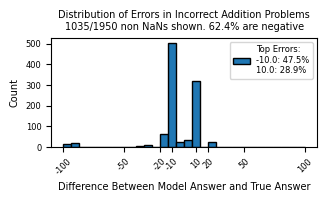

In [19]:
def get_incorrect_diffs(mina = 0, maxa = 99, batch_size = 100):
    df = get_incorrect_df(mina, maxa)
    df = df.reset_index(drop=True)
    # Process dataframe in batches
    diffs = []
    with torch.no_grad():
        for i in range(0, len(df), batch_size):
            batchdf = df.iloc[i:i + batch_size]
            qtoks = batchdf['q_tok'].values
            answers = np.array(batchdf['answer'].values)
            with model.trace() as tracer:
                with tracer.invoke(qtoks) as invoker: # gets the corrupt hs to patch in
                    pass
                output = model.output.save()
            logits = output.logits[:,-1].cpu()
            model_token_answers = logits.argmax(axis=-1)
            model_answers = model.tokenizer.batch_decode(model_token_answers)
            model_answers = np.array([int(ans) if ans.strip().isdigit() else float('nan') for ans in model_answers])
            diff = model_answers - answers
            diffs.extend([d.item() for d in diff])
    # Save diffs to pickle file
    diffs_array = np.array(diffs)
    pd.to_pickle(diffs_array, 'data_addition/gen_math/data_incorrect_diffs.pkl')
    return diffs_array

def get_diffs():
    return pd.read_pickle('data_addition/gen_math/data_incorrect_diffs.pkl')

def plot_incorrect_diffs():
    # Read the diffs array from pickle file
    diffs_array = get_diffs()
    original_n = len(diffs_array)
    # Remove nans and count valid samples
    valid_diffs = diffs_array[~np.isnan(diffs_array)]
    # Get counts of each unique diff value
    unique_diffs, counts = np.unique(valid_diffs, return_counts=True)
    # Sort by counts in descending order and get top 10
    sorted_indices = np.argsort(-counts)
    top_10_diffs = unique_diffs[sorted_indices[:2]]
    top_10_counts = counts[sorted_indices[:2]]
    n_samples = len(valid_diffs)
    print("\nTop 10 most common error values:")
    top_errors = 'Top Errors:'
    for diff, count in zip(top_10_diffs, top_10_counts):
        top_errors+=f"\n{diff}: {count/n_samples*100:.1f}%"
    
    num_neg = np.sum(valid_diffs < 0) / len(valid_diffs) * 100
    # Create histogram plot
    plt.figure(figsize=(3.25,2))
    plt.hist(valid_diffs, bins=30, edgecolor='black', label = top_errors)
    plt.title(f'Distribution of Errors in Incorrect Addition Problems\n{n_samples}/{original_n} non NaNs shown. {num_neg:.1f}% are negative')
    plt.xlabel('Difference Between Model Answer and True Answer')
    plt.ylabel('Count')
    # Set x-axis to log scale with custom ticks
    #plt.xscale('log')
    plt.xticks([-100, -50, -20, -10,10,20,50,100], ['-100', '-50', '-20', '-10', '10','20','50','100'], rotation=45)
    # Save the figure
    plt.legend()    
    plt.tight_layout()
    plt.savefig('figs_addition/model_errors/incorrect_diff_hist.png', bbox_inches = 'tight', dpi = 300)
    plt.show()
    plt.close()

#get_incorrect_diffs()
plot_incorrect_diffs()

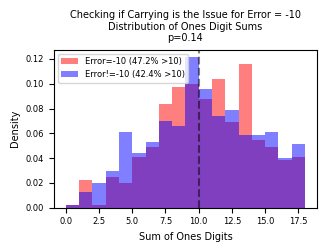

In [22]:
def check_carrying_error():
    # Load and filter data
    df = get_incorrect_df(mina=0, maxa=99)[~np.isnan(get_diffs())]
    diffs = get_diffs()[~np.isnan(get_diffs())]
    
    # Get ones digits and their sums
    ones_sum = (df['a'] % 10 + df['b'] % 10).values
    
    # Calculate stats for diff=-10 vs others
    neg_10_mask = diffs == -10
    pct_carry = {
        'neg_10': np.mean(ones_sum[neg_10_mask] > 10) * 100,
        'other': np.mean(ones_sum[~neg_10_mask] > 10) * 100
    }
    
    # Chi-square test
    _, pvalue = stats.chi2_contingency(pd.crosstab(diffs == -10, ones_sum > 10))[:2]
    
    # Plot histograms
    plt.figure(figsize=(3.25,2.5))
    plt.hist(ones_sum[neg_10_mask], bins=range(19), alpha=0.5, color='red',
             label=f'Error=-10 ({pct_carry["neg_10"]:.1f}% >10)', density=True)
    plt.hist(ones_sum[~neg_10_mask], bins=range(19), alpha=0.5, color='blue',
             label=f'Error!=-10 ({pct_carry["other"]:.1f}% >10)', density=True)
    
    plt.axvline(x=10, color='black', linestyle='--', alpha=0.5)
    plt.title(f'Checking if Carrying is the Issue for Error = -10\nDistribution of Ones Digit Sums\np={pvalue:.2f}')
    plt.xlabel('Sum of Ones Digits')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig('figs_addition/model_errors/ones_digit_sums_by_error.png', bbox_inches = 'tight', dpi = 300)
    plt.show()
    plt.close()

check_carrying_error()

# Analayze patterns in logits

In [34]:
def generate_logits(mina = 0, maxa = 99, batch_size = 100):
    df = get_gen_math(mina, maxa)
    _, atoks = get_output_tokens(mina, maxa)
    all_logits = []
    with torch.no_grad():
        for i in tqdm(range(0, len(df), batch_size)):
            batchdf = df.iloc[i:i + batch_size]
            qtoks = batchdf['q_tok'].values
            with model.trace() as tracer:
                with tracer.invoke(qtoks) as invoker: # gets the corrupt hs to patch in
                    pass
                output = model.output.save()
            logits = output.logits[:,-1].cpu().detach().float().numpy()
            logit_vals = logits[:,atoks]
            all_logits.append(logit_vals)
    # Stack all batches into one array
    all_logits = np.vstack(all_logits)
    # Save results to pickle file
    results = {
        'logits': all_logits,
        'df': df
    }
    filename = f'data_addition/logit_investigation/logits_mina{mina}_maxa{maxa}.pkl'
    pd.to_pickle(results, filename)
    return all_logits
#generate_logits()

In [23]:
def get_logits(mina = 0, maxa = 99):
    filename = f'data_addition/logit_investigation/logits_mina{mina}_maxa{maxa}.pkl'
    results = pd.read_pickle(filename)
    return results['logits'], results['df']

def get_linear(logits):
    x = np.arange(len(logits))
    a, b = np.polyfit(x, logits, 1)
    return x, a, b

def get_frequencies(logit_vals):
    # Perform FFT on the logit values
    N = len(logit_vals)
    # Normalize logit_vals to [-1, 1] range before FFT
    logit_vals_norm = 2 * (logit_vals - np.min(logit_vals)) / (np.max(logit_vals) - np.min(logit_vals)) - 1
    yf = fft(logit_vals_norm)
    xf = fftfreq(N)
    # Get the magnitude spectrum
    magnitude_spectrum = 2.0/N * np.abs(yf[:N//2])
    frequencies = xf[:N//2]
    # Find top period components
    num_components = 5
    top_indices = np.argsort(magnitude_spectrum)[-num_components:][::-1]
    # Convert frequencies to periods (1/f), avoiding division by 0
    frequencies_abs = np.abs(frequencies[top_indices])
    # Filter out zero frequencies first
    nonzero_mask = frequencies_abs > 0
    top_periods = np.zeros_like(frequencies_abs)
    top_periods[nonzero_mask] = 1/frequencies_abs[nonzero_mask]
    top_magnitudes = magnitude_spectrum[top_indices]
    # Filter out infinite periods (where frequency was 0)
    valid_mask = ~np.isinf(top_periods)
    top_periods = top_periods[valid_mask][1:] # first one is 0
    top_magnitudes = top_magnitudes[valid_mask][1:]
    # Return the top period components and their magnitudes
    return list(zip(top_periods, top_magnitudes))


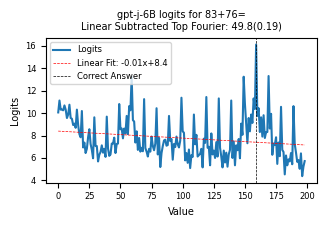

In [35]:
def plot_logits(a,b):
    alllogits, df = get_logits()
    entry = df[(df['a'] == a) & (df['b'] == b)].iloc[0]
    ans = entry['answer']
    idx = df.index.get_loc(entry.name)
    logits = alllogits[idx]
    xs, slope, intercept = get_linear(logits)
    prediction = slope * xs + intercept
    subtracted = logits - prediction
    freqs = get_frequencies(subtracted)
    freq_str = ', '.join([f'{f[0]:.1f}({f[1]:.2f})' for f in freqs[:1]])
    plt.figure(figsize = (3.25,2.25))
    plt.plot(logits,label =  'Logits')
    plt.plot(xs, prediction, linestyle = '--', color = 'r', lw = 0.5, label = f'Linear Fit: {slope:.2f}x+{intercept:.1f}')
    plt.axvline(ans, color = 'k', linestyle = '--', linewidth = 0.5, label = 'Correct Answer')
    plt.title(f'{MODEL_NAME} logits for {a}+{b}=\nLinear Subtracted Top Fourier: {freq_str}')
    plt.xlabel('Value')
    plt.ylabel('Logits')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figs_addition/logit_fourier/{a}+{b}_logits.png', bbox_inches = 'tight', dpi = 300)
    plt.show()
    plt.close()

plot_logits(83, 76)

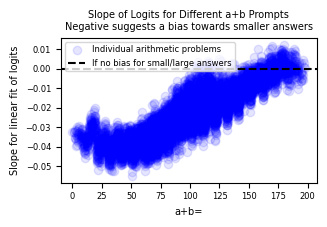

In [39]:
def investigate_linear(mina = 0, maxa = 99):
    alllogits, df = get_logits()
    slopes = []
    for logits in alllogits:
        _, slope, _ = get_linear(logits)
        slopes.append(slope)
    # Save data with hyperparameters in filename
    save_data = {
        'slopes': slopes,
        'a': df['a'].values,
        'b': df['b'].values,
        'answer':df['answer'].values
    }
    os.makedirs('data_addition/logit_investigation', exist_ok=True)
    filename = f'data_addition/logit_investigation/logit_slope_min{mina}_max{maxa}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(save_data, f)


def plot_logit_slopes():
    # Read data
    filename = 'data_addition/logit_investigation/logit_slope_min0_max99.pkl'
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    x = data['answer']
    slope = data['slopes']
    plt.figure(figsize = (3.25,2.25))
    plt.scatter(x, slope, color = 'b', alpha = 0.1, label = 'Individual arithmetic problems')
    plt.axhline(0, color = 'k', linestyle = '--', label = 'If no bias for small/large answers')
    plt.xlabel('a+b=')
    plt.ylabel('Slope for linear fit of logits')
    plt.title('Slope of Logits for Different a+b Prompts\nNegative suggests a bias towards smaller answers')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figs_addition/logit_summaries/logit_slopes.png', bbox_inches = 'tight', dpi = 300)
    plt.show()

#investigate_linear()
plot_logit_slopes()


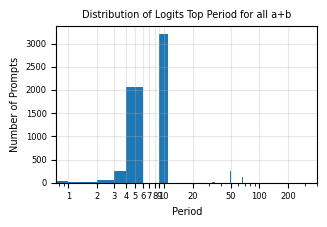

In [46]:
def investigate_fourier(mina = 0, maxa = 99):
    alllogits, df = get_logits()
    x = np.linspace(0,300,301)
    mags = np.zeros_like(x)
    appearances = np.zeros_like(x)
    top1 = np.zeros_like(x)
    for logits in alllogits:
        xs, slope, intercept = get_linear(logits)
        prediction = slope * xs + intercept
        subtracted = logits - prediction
        freqs = get_frequencies(subtracted)
        i = 0
        for freq, mag in freqs:
            # Find index of closest x value to freq
            idx = np.abs(x - freq).argmin()
            mags[idx] += mag
            appearances[idx] += 1
            if i == 0:
                top1[idx] +=1
            i+=1
    # Save data with hyperparameters in filename
    save_data = {
        'x': x,
        'mags': mags, 
        'appearances': appearances,
        'top1': top1,
        'min_a': mina,
        'max_a': maxa
    }
    os.makedirs('data_addition/logit_investigation', exist_ok=True)
    filename = f'data_addition/logit_investigation/logit_fourier_min{mina}_max{maxa}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(save_data, f)


def plot_logit_freqs():
    # Read data
    filename = 'data_addition/logit_investigation/logit_fourier_min0_max99.pkl'
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    x = data['x']
    plots = [('top1', 'Top Period')]#,('mags', 'Frequency Magnitudes'), ('appearances', 'Top 5 Frequencies'), ]
    
    for i, (key, label) in enumerate(plots, 1):
        plt.figure(figsize=(3.25,2.25))
        plt.bar(x, data[key], width=2)
        plt.title(f'Distribution of Logits {label} for all a+b')
        plt.xlabel('Period')
        plt.ylabel('Number of Prompts')
        plt.grid(True, alpha=0.3)
        plt.xscale('log')
        plt.xticks([1,2,3,4,5,6,7,8,9,10,20,50,100,200], 
                   ['1','2','3','4','5','6','7','8','9','10','20','50','100','200'])
        os.makedirs('figs_addition/logit_summaries', exist_ok=True)
        plt.tight_layout()
        plt.savefig(f'figs_addition/logit_summaries/logit_fourier_{key}.png', bbox_inches = 'tight', dpi = 300)
        plt.show()
        plt.close()

#investigate_fourier()
plot_logit_freqs()

# Logit Lens Neurons
Here, we want to logit lens the outputs of neurons to see what kind of shape they take
Ideal function: given a neuron idx, does logit lens for top k activations, and plots it as a graph (xaxis is value 0-198 and yaxis is logit)

In [47]:
def get_neuron_prepostact(mina = 0, maxa = 99):
    with open(f'data_addition/prepost_acts/neuron_prepostact_results_mina{mina}_maxa{maxa}.pkl', 'rb') as f:
        results = pickle.load(f)
    preacts, postacts, neurondf = results['pre_acts'], results['post_acts'], results['neurondf']
    return preacts, postacts, neurondf

def get_neuron_idx(idx):
    preacts, postacts, neurondf = get_neuron_prepostact()
    return preacts[idx], postacts[idx], neurondf.iloc[idx]

def get_topk_acts(idx, k=10, method='top'):
    _, post, _ = get_neuron_idx(idx)
    
    if method == 'top':
        # Get top k values as before
        flat_indices = np.argpartition(post.flatten(), -k)[-k:]
        topk_y, topk_x = np.unravel_index(flat_indices, post.shape)
        topk_values = post[topk_y, topk_x]
        sorted_indices = np.argsort(-topk_values)
        topk_values = topk_values[sorted_indices]
        topk_b = topk_x[sorted_indices]
        topk_a = topk_y[sorted_indices]
        return topk_a, topk_b, topk_values
        
    elif method == 'spaced':
        # Get evenly spaced values
        values = post
        if len(values) == 0:
            return np.array([]), np.array([]), np.array([])
        # Get evenly spaced values between min and max
        min_val = np.min(values)
        max_val = np.max(values)
        spaced_values = np.linspace(max_val, min_val, k)
        # Find indices of closest values
        selected_indices = []
        sorted_values = -np.sort(-values.flatten()) # Sort descending
        used_indices = set()
        for target in spaced_values:
            # Find closest value that hasn't been used yet
            remaining_indices = [i for i in range(len(sorted_values)) if i not in used_indices]
            if not remaining_indices:
                break
            diffs = np.abs(sorted_values[remaining_indices] - target)
            closest_idx = remaining_indices[np.argmin(diffs)]
            selected_indices.append(closest_idx)
            used_indices.add(closest_idx)
        selected_indices = np.array(selected_indices)
        # Map back to original indices
        sorted_indices = np.argsort(-values.flatten())
        original_indices = sorted_indices[selected_indices]
        # Get original coordinates
        topk_a, topk_b = np.unravel_index(original_indices, values.shape)
        topk_values = values[topk_a, topk_b]
        
        return topk_a, topk_b, topk_values

def get_df_topacts(idx, k=10, method='top'):
    topa, topb, _ = get_topk_acts(idx, k=k, method=method)
    df = get_gen_math()
    # Create a list of tuples from topa and topb
    top_pairs = list(zip(topa, topb))
    # Create a dictionary mapping (a,b) pairs to their index in top_pairs
    pair_to_idx = {pair: idx for idx, pair in enumerate(top_pairs)}
    # Filter df to keep only rows where (a,b) matches one of the top pairs
    filtered_df = df[df.apply(lambda row: (row['a'], row['b']) in top_pairs, axis=1)].copy()
    # Sort filtered_df based on the order in top_pairs
    filtered_df.loc[:,'sort_idx'] = filtered_df.apply(lambda row: pair_to_idx[(row['a'], row['b'])], axis=1)
    filtered_df = filtered_df.sort_values('sort_idx').drop('sort_idx', axis=1)
    return top_pairs, filtered_df

#a,b,val = get_topk_acts(1586, k = 100, method = 'spaced')
top_pairs, filtered_df = get_df_topacts(1586, k = 100, method = 'spaced')


In [48]:
def run_logit_lens(idx, k = 100, method = 'spaced'):
    _, _, ndf = get_neuron_idx(idx)
    layer, neuron_idx, log_diff = int(ndf['layer']), int(ndf['neuron_idx']), ndf['logit_difference']
    top_pairs, filtered_df = get_df_topacts(idx, k = k, method = method)
    possible_ans_tokens = get_output_tokens()[1]
    q_toks = torch.stack([torch.tensor(x) for x in filtered_df['q_tok'].values])
    answers = filtered_df['answer'].values
    with model.trace() as tracer:
        with tracer.invoke(q_toks) as invoker:
            neuron_val = model.transformer.h[layer].mlp.act.output[:,-1, neuron_idx].unsqueeze(1).save() #k, 1
            neuron_projection = model.transformer.h[layer].mlp.fc_out.weight[:, neuron_idx].unsqueeze(0)  #1, model_dim
            neuron_nl = (neuron_val * neuron_projection).save()
            #neuron_nl  = model.transformer.ln_f(neuron_act).save()
            neuron_output = model.lm_head(neuron_nl)
            logits = neuron_output[:, possible_ans_tokens].save() 
    logits = logits.cpu().detach().float().numpy()
    neuron_val = neuron_val[:,0].cpu().detach().float().numpy()
    save_dir = "data_addition/neuron_logit_lens"
    os.makedirs(save_dir, exist_ok=True)
    filename = f"{idx}. L{layer}N{neuron_idx}.pkl"
    save_path = os.path.join(save_dir, filename)
    data_to_save = {
        'top_pairs': top_pairs,
        'answers': answers,
        'logits': logits,
        'neuron_val': neuron_val,
        'layer_neuron_logdiff': (layer, neuron_idx, log_diff)
    }
    with open(save_path, 'wb') as f:
        pickle.dump(data_to_save, f, protocol=pickle.HIGHEST_PROTOCOL)
    return top_pairs, answers, logits, neuron_val

def run_all_logit_lens(start = 0):
    ndf = get_neuron_prepostact()[-1]
    end = len(ndf)
    for i in tqdm(range(start, end)):
        run_logit_lens(i)
#run_all_logit_lens(0)

# Plot Distribution of topk fourier components of logits

In [44]:
def load_path_patch():
    df = pd.read_csv('data_addition/neuron_path_patching.csv', index_col=False)
    df = df.rename(columns={'Unnamed: 0': 'original_index'})
    return df
def get_path_patch_threshold(threshold=0.7):
    df = load_path_patch()
    df = df.sort_values('path_patch', ascending=False).reset_index(drop=True)
    total_effect = df['path_patch'].sum()
    target_value = total_effect * threshold
    neuron_idx = (df['path_patch'].cumsum() >= target_value).idxmax()
    return df.iloc[:neuron_idx+1]

In [49]:
def read_logit_lens(idx):
    save_dir = "data_addition/neuron_logit_lens"
    for filename in os.listdir(save_dir):
        if filename.startswith(f"{idx}."):
            save_path = os.path.join(save_dir, filename)
            with open(save_path, 'rb') as f:
                data = pickle.load(f)
            break
    return data


def fourier_logits_topk(idx, topk=3):
    data = read_logit_lens(idx)
    logits = data['logits'][0]
    nums = list(range(logits.shape[0]))
    # Compute FFT of the logits
    fft = np.fft.fft(logits)
    # Get frequencies
    freqs = np.fft.fftfreq(len(nums))
    
    # Get positive frequencies only
    pos_freqs = freqs[1:len(freqs)//2]
    pos_fft = np.abs(fft[1:len(fft)//2])
    
    # Find frequencies with top k amplitudes
    dominant_freq_idxs = np.argsort(pos_fft)[-topk:][::-1]
    dominant_freqs = pos_freqs[dominant_freq_idxs]
    
    # Convert frequencies to periods
    dominant_periods = np.abs(1/dominant_freqs)
    
    return dominant_periods.tolist()



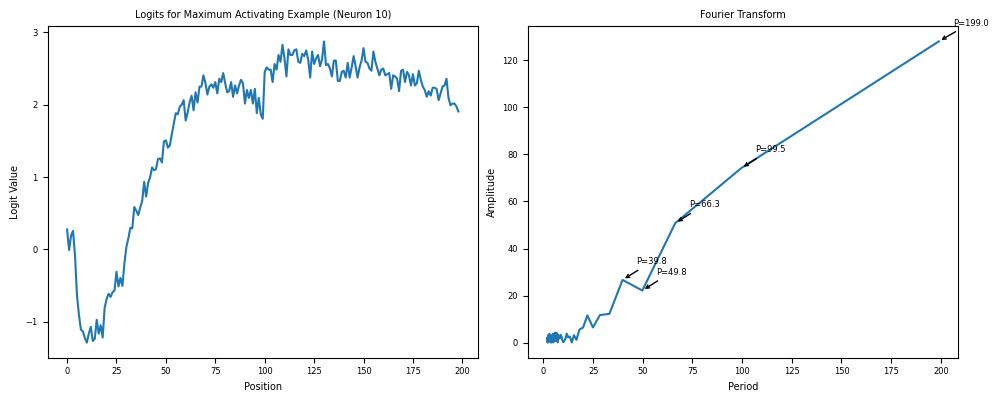

In [55]:
def plot_fourier_logits(idx, show = True):
    data = read_logit_lens(idx)
    logits = data['logits'][0]
    nums = list(range(logits.shape[0]))
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    
    # Plot original logits
    ax1.plot(nums, logits)
    ax1.set_title(f'Logits for Maximum Activating Example (Neuron {idx})')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Logit Value')
    
    # Compute FFT
    fft = np.fft.fft(logits)
    freqs = np.fft.fftfreq(len(nums))
    
    # Get positive frequencies only
    pos_freqs = freqs[1:len(freqs)//2]
    pos_fft = np.abs(fft[1:len(fft)//2])
    
    # Find frequencies with top 5 amplitudes
    top5_idx = np.argsort(pos_fft)[-5:][::-1]
    top5_freqs = pos_freqs[top5_idx]
    top5_periods = np.abs(1/top5_freqs)
    top5_amps = pos_fft[top5_idx]
    
    # Plot FFT
    periods = np.abs(1/pos_freqs)
    ax2.plot(periods, pos_fft)
    ax2.set_title('Fourier Transform')
    ax2.set_xlabel('Period')
    ax2.set_ylabel('Amplitude')
    
    # Label top 5 peaks
    for i, (period, amp) in enumerate(zip(top5_periods, top5_amps)):
        ax2.annotate(f'P={period:.1f}', 
                    xy=(period, amp),
                    xytext=(10, 10),
                    textcoords='offset points',
                    ha='left',
                    va='bottom',
                    arrowprops=dict(arrowstyle='->'))
    
    plt.tight_layout()
    # Save figure
    save_path = 'figs_addition/neuron_logit_lens/neuron_logit_lens_fourier'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path+f'/{idx}.png')
    if show:
        plt.show()
    plt.close()

def plot_all_fourier_logits():
    top_neurons = get_path_patch_threshold(0.8)
    # Run fits for each neuron index
    for idx in tqdm(top_neurons.index):
        plot_fourier_logits(idx, show = False)
#fourier_logits_topk(21,5)
plot_fourier_logits(10)


Top 10 most common periods:
1. Period 199.0: 235 occurrences
2. Period 99.5: 132 occurrences
3. Period 10.0: 76 occurrences
4. Period 5.0: 69 occurrences
5. Period 49.8: 32 occurrences
6. Period 2.0: 32 occurrences
7. Period 3.3: 25 occurrences
8. Period 3.0: 25 occurrences
9. Period 2.5: 20 occurrences
10. Period 66.3: 18 occurrences


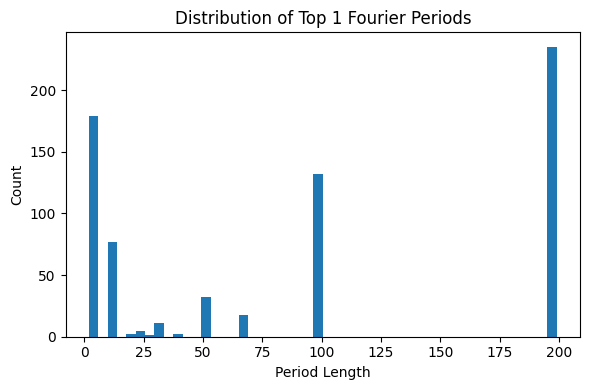

In [109]:
# Calculate FOurier
def run_fourier_dist(k):
    ndf = get_path_patch_threshold(0.8)
    # Calculate dominant periods for each neuron
    periods_list = []
    for idx in tqdm(range(len(ndf))):
        periods = fourier_logits_topk(idx, k)
        periods_list.append(periods)
    
    # Add as new column
    ndf['fourier_periods'] = periods_list
    
    # Save dataframe
    save_path = 'data_addition/neuron_logit_lens/neuron_df_fourier.pkl'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    ndf.to_pickle(save_path)

    
    # Function to read back the data
def read_neuron_df_fourier():
    path = 'data_addition/neuron_logit_lens/neuron_df_fourier.pkl'
    return pd.read_pickle(path)

def plot_dist(k):
    assert k<=5, 'Not enough data made to plot'
    # Read the dataframe with Fourier periods
    df = read_neuron_df_fourier()
    
    # Extract first k periods from each row's list, round to nearest int, and flatten into 1D array
    periods = np.array([row[:k] for row in df['fourier_periods']]).flatten()
    periods = np.round(periods * 10) / 10
    
    # Get counts of unique periods
    unique_periods, counts = np.unique(periods, return_counts=True)
    # Get indices of top 10 most common periods
    top10_idx = np.argsort(counts)[-10:][::-1]
    print("\nTop 10 most common periods:")
    for i, idx in enumerate(top10_idx):
        print(f"{i+1}. Period {unique_periods[idx]}: {counts[idx]} occurrences")
    
    # Create single plot
    plt.figure(figsize=(6, 4))
    plt.hist(periods, bins=50)
    plt.title(f'Distribution of Top {k} Fourier Periods')
    plt.xlabel('Period Length')
    plt.ylabel('Count')
    
    plt.tight_layout()
    
    # Save figure
    save_dir = "figs_addition/neuron_logit_lens/fourier"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"fourier_period_dist_top{k}.png")
    plt.savefig(save_path)
    
    plt.show()
plot_dist(1)

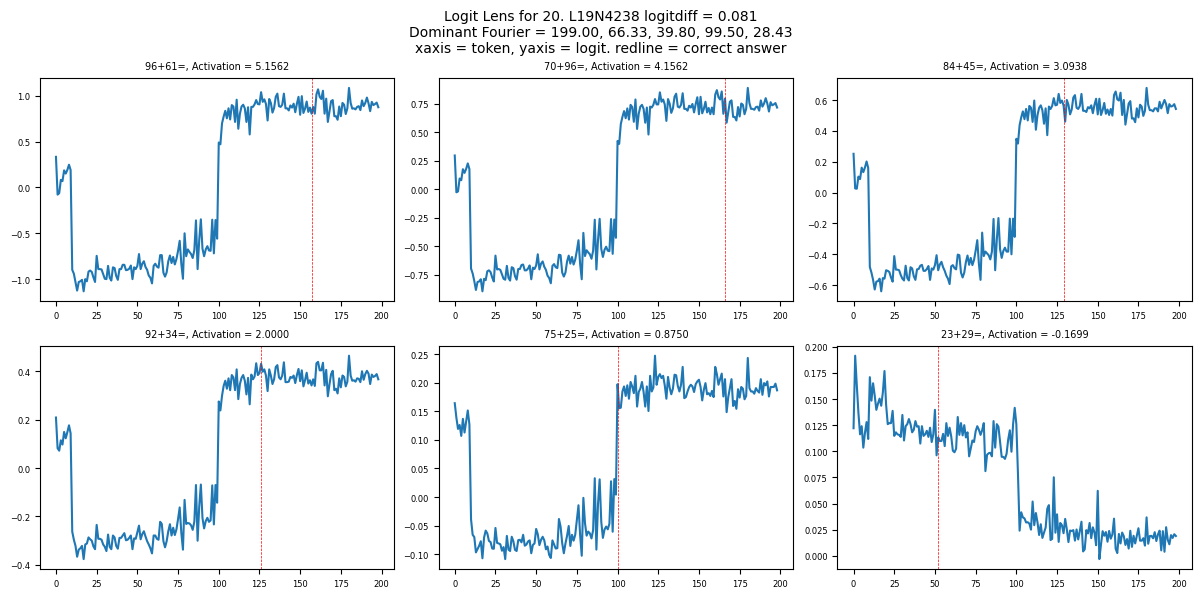

In [56]:

def plot_logit_lens(idx, k = 6, show = True):
    # Get evenly spaced indices
    data = read_logit_lens(idx)
    total_examples = len(data['logits'])
    indices = np.linspace(0, total_examples-1, k, dtype=int)
    layer, neuron_idx, log_diff = data['layer_neuron_logdiff']
    fourier = fourier_logits_topk(idx,5)
    
    # Create a figure with k/2 rows and 2 columns of subplots
    fig, axs = plt.subplots( 2,k//2, figsize=(12, 2*k//2))
    axs = axs.ravel()  # Flatten the 2D array of axes
    fig.suptitle(f'Logit Lens for {idx}. L{layer}N{neuron_idx} logitdiff = {log_diff:.3f}\nDominant Fourier = {", ".join([f"{x:.2f}" for x in fourier])}\nxaxis = token, yaxis = logit. redline = correct answer')
    # Plot k evenly spaced examples
    for idx_plot, i in enumerate(indices):
        a,b = data['top_pairs'][i]
        ans = data['answers'][i]
        axs[idx_plot].plot(data['logits'][i], label='Logits')
        axs[idx_plot].axvline(ans, color='r', linestyle='--', lw=0.5, label='Correct Answer')
        axs[idx_plot].set_title(f'{a}+{b}=, Activation = {data["neuron_val"][i]:.4f}')
    plt.tight_layout()
    # Save figure
    save_dir = "figs_addition/neuron_logit_lens"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{idx}. L{layer}N{neuron_idx}.png")
    plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()

def plot_all_logit_lens(start = 0):
    top_neurons = get_path_patch_threshold(0.8)
    # Run fits for each neuron index
    for idx in tqdm(top_neurons['original_index']):
        plot_logit_lens(idx, show = False)
#run_all_plot_logit_lens(0)
plot_logit_lens(20)
#read_logit_lens(1934)
#plot_all_logit_lens()

# Logit Lens Fitting

In [50]:
class MultiCosineModel(nn.Module):
    def __init__(self, idx, periods=torch.tensor([2, 5, 10, 100, 200], dtype=torch.float)):
        super(MultiCosineModel, self).__init__()
        self.periods = periods
        num_cosine_terms = len(periods)  # One term per period (a+b)
        # Initialize amplitudes randomly
        self.amplitudes = nn.Parameter(torch.randn(num_cosine_terms, requires_grad=True))
        self.offsets = nn.Parameter(torch.randn(num_cosine_terms, requires_grad=True))
        # Learnable parameters for linear term
        self.linear_weight = nn.Parameter(torch.randn(1, requires_grad=True))  # For a+b
        # Bias term
        self.bias = nn.Parameter(torch.zeros(1, requires_grad=True))

    def forward(self, a_plus_b):
        # Rescale a+b to [-1, 1]
        apb_min, apb_max = torch.min(a_plus_b), torch.max(a_plus_b)
        a_plus_b_scaled = 2 * (a_plus_b - apb_min) / (apb_max - apb_min) - 1

        # Compute cosine terms
        cos_terms = []
        for i, T in enumerate(self.periods):
            cos_terms.append(self.amplitudes[i] * torch.cos(2 * torch.pi / T * (a_plus_b - self.offsets[i])))

        # Compute linear term using the scaled value
        linear_term = self.linear_weight * a_plus_b_scaled

        # Combine all terms
        return sum(cos_terms) + linear_term + self.bias


def train(idx, a_plus_b, N, lr = 1, epochs = 10000):
    a_plus_b, N_actual = torch.tensor(a_plus_b),torch.tensor(N).float()
    # Initialize the model
    model = MultiCosineModel(idx)
    # Define MSE loss criterion
    criterion = nn.MSELoss()
    
    optimizer = optim.SGD(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    #bar = tqdm(range(epochs))
    for epoch in range(epochs):#bar:
        # Zero the gradient buffers
        optimizer.zero_grad()
        N_pred = model(a_plus_b)  # Pass inputs to the model
        # Use MSE loss
        loss = criterion(N_pred, N_actual)
        loss.backward()
        optimizer.step()
        scheduler.step()
        #bar.set_postfix({'Epoch':f'{epoch + 1}/{epochs}', 'Loss': f'{loss.item():.4f}'})
    N_pred = model(a_plus_b)
    mse = torch.mean((N_pred - N_actual)**2)
    rmse = torch.sqrt(mse)
    nrmse = rmse / (torch.max(N_actual) - torch.min(N_actual))
    return model, N_pred, nrmse


def run_fit(idx):
    data = read_logit_lens(idx)
    logits = data['logits'][0]
    max_mult = np.abs(logits).max()
    logits = logits / max_mult
    nums = list(range(0,logits.shape[0]))
    model, N_pred, nrmse = train(idx, nums, logits)
    N_pred = N_pred.detach().numpy() 
    np.savez(f'data_addition/neuron_logit_lens_fits/neuron_{idx}.npz',
             model=model.state_dict(),
             predictions=N_pred,
             nrmse=nrmse.item(),
             max_mult = max_mult)
#run_fit(5)

def run_all_fits():
    top_neurons = get_path_patch_threshold(0.8)
    # Run fits for each neuron index
    for idx in tqdm(top_neurons['original_index']):
        if idx < 1545:
            continue
        try:
            run_fit(idx)
        except Exception as e:
            print(f"Failed to run fit for neuron {idx}: {str(e)}")
#run_all_fits()
for f in tqdm([1099, 1169, 976, 752, 1007, 702, 1146, 1407, 801, 782, 751, 1431, 876, 1036, 778, 1164]):
    run_fit(f)

100%|███████████████████████████████████████████████████████| 16/16 [01:19<00:00,  4.96s/it]


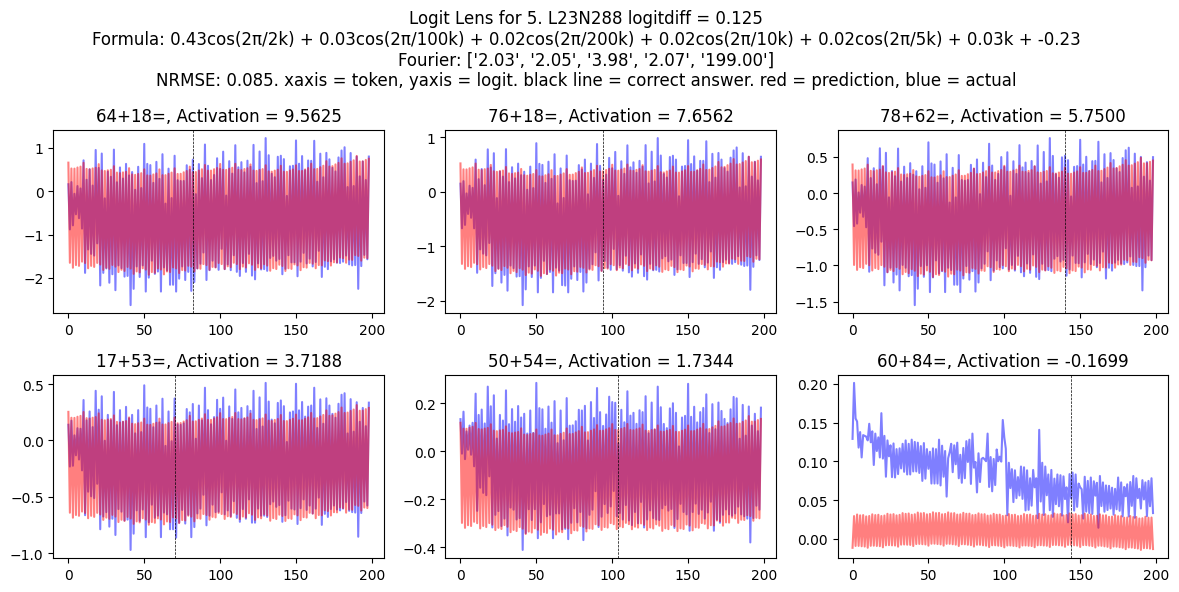

In [144]:
def create_formula(model_state):
    amps = model_state['amplitudes']
    offset = model_state['offsets']
    lw = model_state['linear_weight'].item()
    bias = model_state['bias'].item()
    periods = [2,5,10,100,200]
    terms = []
    # Create list of tuples with (amplitude, period, offset) and sort by absolute amplitude
    term_data = list(zip(amps, periods, offset))
    term_data.sort(key=lambda x: abs(x[0]), reverse=True)
    
    # Create terms in order of descending amplitude
    for amp, period, off in term_data:
        term = f"{amp:.2f}cos(2π/{period}k)"# - {off:.2f}))'
        terms.append(term)
    formula = " + ".join(terms)
    # Add linear term and bias
    if lw != 0:
        formula += f" + {lw:.2f}k"
    if bias != 0:
        formula += f" + {bias:.2f}"
    return formula

def plot_logit_lens_fits(idx, k=6, show=True):
    # Get data for both plots
    data = read_logit_lens(idx)
    logits = data['logits'] 
    max_mult = np.abs(logits[0]).max()
    fit_data = np.load(f'data_addition/neuron_logit_lens_fits/neuron_{idx}.npz', allow_pickle=True)
    model_state = fit_data['model'].item()
    predictions = fit_data['predictions'] * max_mult
    nrmse = fit_data['nrmse']
    formula = create_formula(model_state)
    fourier = fourier_logits_topk(idx,5)
    
    # Get evenly spaced indices for logit lens panels
    total_examples = len(data['logits'])
    indices = np.linspace(0, total_examples-1, k, dtype=int)
    layer, neuron_idx, log_diff = data['layer_neuron_logdiff']
    
    # Create figure with k/2 rows and 2 columns for logit lens, plus one row for prediction
    fig, axs = plt.subplots(2, k//2, figsize=(12, 6), gridspec_kw={'height_ratios': [1, 1]})
    axs = axs.ravel()  # Flatten the 2D array of axes
    
    # Title with formula and nrmse
    fig.suptitle(f'Logit Lens for {idx}. L{layer}N{neuron_idx} logitdiff = {log_diff:.3f}\n' + 
                f'Formula: {formula}\nFourier: {[f"{x:.2f}" for x in fourier]}\nNRMSE: {nrmse:.3f}. xaxis = token, yaxis = logit. black line = correct answer. red = prediction, blue = actual')
    
    # Plot k evenly spaced examples in first 6 panels
    max_act = data['neuron_val'].max()
    for idx_plot, i in enumerate(indices):
        a,b = data['top_pairs'][i]
        ans = data['answers'][i]
        act = data["neuron_val"][i]
        nums = list(range(predictions.shape[0]))
        prediction = predictions * act / max_act
        axs[idx_plot].plot(nums, logits[i], color = 'b', alpha = 0.5, label='Actual')
        axs[idx_plot].plot(nums, prediction, color ='r', alpha = 0.5,label='Prediction')
        axs[idx_plot].axvline(ans, color='k', linestyle='--', lw=0.5, label='Correct Answer')
        axs[idx_plot].set_title(f'{a}+{b}=, Activation = {act:.4f}')
    
    plt.tight_layout()
    
    # Save figure
    save_dir = "figs_addition/neuron_logit_lens_fits"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{idx}. L{layer}N{neuron_idx}.png")
    plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()

def plot_all_logit_lens_fits():
    top_neurons = get_path_patch_threshold(0.8)
    # Run fits for each neuron index
    for idx in tqdm(top_neurons.index):
        try:
            plot_logit_lens_fits(idx, show = False)
        except Exception as e:
            print(f"Failed to run fit for neuron {idx}: {str(e)}")
#plot_all_logit_lens_fits()
plot_logit_lens_fits(5)

# Logit Investigation

In [57]:
def get_activations(a,b):
    #_, post, _ = get_neuron_idx(4)
    f  = read_logit_lens(0)
    print(f)

get_activations(0,99)

{'top_pairs': [(np.int64(8), np.int64(18)), (np.int64(80), np.int64(18)), (np.int64(76), np.int64(18)), (np.int64(28), np.int64(18)), (np.int64(6), np.int64(18)), (np.int64(18), np.int64(40)), (np.int64(38), np.int64(18)), (np.int64(8), np.int64(28)), (np.int64(72), np.int64(18)), (np.int64(16), np.int64(72)), (np.int64(40), np.int64(18)), (np.int64(58), np.int64(18)), (np.int64(62), np.int64(16)), (np.int64(16), np.int64(62)), (np.int64(26), np.int64(60)), (np.int64(44), np.int64(16)), (np.int64(6), np.int64(58)), (np.int64(60), np.int64(40)), (np.int64(18), np.int64(62)), (np.int64(28), np.int64(32)), (np.int64(18), np.int64(52)), (np.int64(94), np.int64(40)), (np.int64(68), np.int64(50)), (np.int64(58), np.int64(44)), (np.int64(14), np.int64(44)), (np.int64(48), np.int64(50)), (np.int64(98), np.int64(50)), (np.int64(42), np.int64(8)), (np.int64(76), np.int64(54)), (np.int64(0), np.int64(6)), (np.int64(66), np.int64(78)), (np.int64(86), np.int64(78)), (np.int64(56), np.int64(82)), (n

# Dashboard

In [40]:
from IPython.display import display, Image, IFrame
import ipywidgets as widgets
def show_plots(idx):
    # Build file paths

    # Find files containing the pattern in each directory
    dir_logit_lens = "figs_addition/neuron_logit_lens"
    listdir_logit_lens = [os.path.join(dir_logit_lens, f) for f in os.listdir(dir_logit_lens)]
    logit_lens_file = [f for f in listdir_logit_lens if f"/{idx}." in f][0]
    logit_lens_fit_file = [f for f in listdir_logit_lens if f"/{idx}." in f][0]
    pre_post_file = [f for f in os.listdir(f"figs_addition/neuron_graphs/mina0_maxa99") if f"idx{idx}_" in f][0]
    fit_file = [f for f in os.listdir(f"figs_addition/neuron_fits/0_99") if f"idx{idx}." in f][0]
    pre_post_file = os.path.join("figs_addition/neuron_graphs/mina0_maxa99", pre_post_file)
    fit_file = os.path.join("figs_addition/neuron_fits/0_99", fit_file)
    # Display the images (assuming they exist)
    display(Image(filename=pre_post_file))
    display(Image(filename=logit_lens_file))
    display(Image(filename=logit_lens_fit_file))
    #display(IFrame(src=fit_file, width='100%', height='600px'))

    


#show_plots(1)

In [41]:
def get_formula(idx):
    data = np.load(f'data/neuron_fits/neuron_{idx}.npz', allow_pickle=True)
    model_data = data['model']
    periods = [2,5,10,100]
    
    # Collect all terms with their amplitudes
    terms = []
    
    # Add cosine terms
    for i, period in enumerate(periods):
        base_idx = i * 3
        
        # a term
        amp_a = model_data.item()['amplitudes'][base_idx]
        offset_a = model_data.item()['offsets'][base_idx]
        terms.append((abs(amp_a), f"{amp_a:.1f}cos(2π/{period:.0f}(a - {offset_a:.1f})"))
        
        # b term
        amp_b = model_data.item()['amplitudes'][base_idx + 1]
        offset_b = model_data.item()['offsets'][base_idx + 1]
        terms.append((abs(amp_b), f"{amp_b:.1f}cos(2π/{period:.0f}(b- {offset_b:.1f})"))
        
        # a+b term
        amp_ab = model_data.item()['amplitudes'][base_idx + 2]
        offset_ab = model_data.item()['offsets'][base_idx + 2]
        terms.append((abs(amp_ab), f"{amp_ab:.1f}cos(2π/{period:.0f}(a+b - {offset_ab:.1f})"))

    # Add linear terms
    lin_x = model_data.item()['linear_weights'][0]
    lin_y = model_data.item()['linear_weights'][1]
    lin_xy = model_data.item()['linear_weights'][2]
    terms.append((abs(lin_x), f"{lin_x:.2f}a"))
    terms.append((abs(lin_y), f"{lin_y:.2f}b"))
    terms.append((abs(lin_xy), f"{lin_xy:.2f}(a+b)"))
    
    # Add bias
    bias = model_data.item()['bias'][0]

    # Sort by absolute amplitude and extract just the formula strings
    terms.sort(key=lambda x: x[0], reverse=True)
    terms.append((abs(bias), f"{bias:.3f}"))
    formula = [term[1] for term in terms]
    
    return formula

def get_nrmse(idx):
    neurondf = pd.read_pickle('data/all_neuron_fits/results.pkl')['neurondf']
    nrmse = neurondf.loc[idx, 'nrmse']
    return nrmse.item()
get_formula(4)
get_nrmse(12)

0.09176721423864365

In [42]:
import os
import panel as pn

pn.extension()

def generate_dashboard(idx):
    # File paths
    dir_logit_lens = "figs_addition/neuron_logit_lens"
    listdir_logit_lens = [os.path.join(dir_logit_lens, f) for f in os.listdir(dir_logit_lens)]
    logit_lens_file = [f for f in listdir_logit_lens if f"/{idx}." in f][0]
    pre_post_file = [f for f in os.listdir(f"figs_addition/neuron_graphs/mina0_maxa99") if f"idx{idx}_" in f][0]
    fit_file = [f for f in os.listdir(f"figs_addition/neuron_fits/0_99") if f"idx{idx}." in f][0]

    pre_post_file = os.path.abspath(os.path.join("figs_addition/neuron_graphs/mina0_maxa99", pre_post_file))
    logit_lens_file = os.path.abspath(logit_lens_file)
    fit_file = os.path.abspath(os.path.join("figs_addition/neuron_fits/0_99", fit_file))

    # Create Panel components
    pre_post_img = pn.pane.Image(pre_post_file, width=800)
    logit_lens_img = pn.pane.Image(logit_lens_file, width=600)

    # Generate the formula and display it
    formula = get_formula(idx)
    fit_nrmse = get_nrmse(int(idx))
    formula_display = pn.pane.Markdown(f'Fit NRMSE: {fit_nrmse:.2f}\n' + " +\n".join(formula), width=300, styles={'font-size': '20px', 'font-weight': 'bold', 'font-style': 'normal'})

    # Return the dashboard layout with formula on the right
    return pn.Row(
        pn.Column(
            f"# Neuron {idx}",
            pre_post_img,
            logit_lens_img,
        ),
        formula_display,
    )

# Create a TextInput widget
text_input = pn.widgets.TextInput(name="Enter Index", placeholder="Type index here")

# Create an interactive Panel app
def update_dashboard(event):
    idx = text_input.value.strip()
    try:
        # Update the layout with the new dashboard
        dashboard[:] = [generate_dashboard(idx)]
    except Exception as e:
        dashboard[:] = [pn.pane.Markdown(f"### Error: {e}")]

# Attach callback to text input
text_input.param.watch(update_dashboard, "value")

# Initial dashboard layout
dashboard = pn.Column(f"# Type an Index to Load Visualizations")

# Combine text input and dashboard
app = pn.Column(text_input, dashboard)

# Serve the app
app.show()


Launching server at http://localhost:42411


Unable to connect to VS Code server: Error in request.
Error: connect ENOENT /run/user/1001/vscode-ipc-621b7b45-2661-4734-8334-9bdaeca159f9.sock
    at PipeConnectWrap.afterConnect [as oncomplete] (node:net:1606:16) {
  errno: -2,
  code: 'ENOENT',
  syscall: 'connect',
  address: '/run/user/1001/vscode-ipc-621b7b45-2661-4734-8334-9bdaeca159f9.sock'
}
